In [7]:
# # Run ensemble model and submit predictions
# ### Imports

import sys
import os
# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'Petreanu_MEI_generation' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('Petreanu_MEI_generation')[0] + 'Petreanu_MEI_generation'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the Petreanu_MEI_generation folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

print('Working directory:', os.getcwd())

from sensorium.utility.training import read_config

run_config = read_config('run_config.yaml') # Must be set

RUN_NAME = run_config['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.
area_of_interest = run_config['data']['area_of_interest']
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
OUT_NAME = f'runs/{RUN_NAME}'

print(f'Starting evaluation for {RUN_NAME} with area of interest {area_of_interest}')

from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model, get_trainer
import torch

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import tqdm


import warnings

warnings.filterwarnings('ignore')
# ### Load configuration for model

# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'config_m4_ens0.yaml'
config = read_config(config_file)
config['model_config']['data_path'] = f'{OUT_NAME}/data'
print(config)
# ### Prepare dataloader

# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = f'{OUT_NAME}/data'
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
print(folders)

dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

# ### Load trained models

# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    # save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    save_file = f'{OUT_NAME}/config_m4_ens{i}/saved_model_v1.pth'
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

# ### Combine them into one ensemble model

from sensorium.models.ensemble import EnsemblePrediction

ensemble = EnsemblePrediction(model_list, mode='mean')

type(model_list[0])

# ### Generate submission file

# dataset_name = '27204-5-13'

# submission.generate_submission_file(trained_model=ensemble, 
#                                     dataloaders=dataloaders,
#                                     data_key=dataset_name,
#                                     path="notebooks/submission_m4/results/",
#                                     device="cuda")

# ### Evaluate model on all datasets

from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

# #### Test data

tier = "validation"

single_trial_correlation = get_correlations(
    ensemble, dataloaders, tier=tier, device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                       measure_attribute="Single Trial Correlation"
                       )

for k in dataloaders[tier]:
    assert len(df[df['dataset'] == k]) == len(dataloaders[tier][k].dataset.neurons.area), f"Length of df and dataloader not equal, {len(df[df['dataset'] == k])} != {len(dataloaders[tier][k].dataset.neurons.area)}"
    df.loc[df['dataset'] == k, 'area'] = dataloaders[tier][k].dataset.neurons.area

# data_basepath = "../molanalysis/data/IM/"
data_basepath = f'{INPUT_FOLDER}/'
# respmat_data_basepath = f'../molanalysis/MEI_generation/data/{RUN_NAME}'
respmat_data_basepath = f'{OUT_NAME}/data'

for k in dataloaders[tier]:
    data_path = os.path.join(data_basepath, k.split('-')[1].split('_')[0] + '/' + '_'.join(k.split('-')[1].split('_')[1:]))
    celldata = pd.read_csv(data_path + '/celldata.csv')
    celldata = celldata.loc[celldata['roi_name'] == area_of_interest] if area_of_interest is not None else celldata
    # assert len(df[df['dataset'] == k]) == len(celldata), f"Length of df and celldata not equal, {len(df[df['dataset'] == k])} != {len(celldata)} of {k}"
    # df.loc[df['dataset'] == k, 'labeled'] = celldata['redcell'].astype(bool).values
    df.loc[df['dataset'] == k, 'labeled'] = 'test'
    # df.loc[df['dataset'] == k, 'cell_id'] = celldata['cell_id'].values
    df.loc[df['dataset'] == k, 'cell_id'] = 'test'

    # trialdata = pd.read_csv(data_path + '/trialdata.csv')
    # if 'repetition' not in trialdata:
    #     trialdata['repetition'] = np.empty(np.shape(trialdata)[0])
    #     for iT in range(len(trialdata)):
    #         trialdata.loc[iT,'repetition'] = np.sum(trialdata['ImageNumber'][:iT] == trialdata['ImageNumber'][iT])

    # nNeurons = len(celldata)

    # respmat_data_path = os.path.join(respmat_data_basepath, k.split('-')[1].split('_')[0] + '/' + '_'.join(k.split('-')[1].split('_')[1:]), 'data')
    # respmat = np.load(respmat_data_path + '/respmat.npy')
    # respmat = respmat[celldata.index.values]
    

Working directory: c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\Petreanu_MEI_generation
Starting evaluation for with_xy_variability with area of interest V1
{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
df_desc = df.groupby('dataset').describe()
df_desc.loc[("All datasets", )] = df_desc.mean()
# I'm so sorry about this horrible one liner
df_desc.loc[("All datasets, weighted"), ] = df_desc['Single Trial Correlation'].mul((df_desc['Single Trial Correlation']['count'].values.reshape(-1, 1)) / np.sum(df_desc['Single Trial Correlation']['count'].values)).sum().values
# df_desc.to_csv('notebooks/submission_m4/results/validation_pred_description.csv', index = False)
df_desc.to_csv(f'{OUT_NAME}/results/validation_pred_description.csv', index=False)
# df_desc

# get index in folders for LPE10885/2023_10_20 if it exists
true_idx = None
for idx, folder in enumerate(folders):
    if 'LPE10885/2023_10_20' in folder:
        true_idx = idx
        break

num_neurons = df_desc['Single Trial Correlation']['count'].iloc[true_idx].astype(int)

mus = np.zeros((5, num_neurons, 2))
sigmas = np.zeros((5, num_neurons, 2, 2))

# model.readout._modules


In [10]:
num_neurons

1173

In [12]:
celldata

,Unnamed: 0,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,yloc,redcell,...,depth,power_mw,meanF,meanF_chan2,noise_level,event_rate,cell_id,layer,recombinase,session_id
0,0,1.0,0.994602,9.800640,6.833180,147.0,219.0,44.0,438.0,0.0,...,90.0,19.000000,723.48250,99.784485,0.063999,0.017700,LPE12223_2024_06_11_0_0000,L2/3,non,LPE12223_2024_06_11
1,1,1.0,0.971501,4.197744,6.448718,123.0,146.0,72.0,26.0,0.0,...,90.0,19.000000,625.00726,33.374718,0.072386,0.045357,LPE12223_2024_06_11_0_0001,L2/3,non,LPE12223_2024_06_11
2,2,1.0,0.850381,2.885499,6.457601,129.0,194.0,36.0,186.0,0.0,...,90.0,19.000000,371.52150,33.329470,0.129849,0.070170,LPE12223_2024_06_11_0_0002,L2/3,non,LPE12223_2024_06_11
3,3,1.0,0.974002,6.701863,6.296358,96.0,116.0,164.0,454.0,0.0,...,90.0,19.000000,764.85175,86.656490,0.069977,0.033030,LPE12223_2024_06_11_0_0003,L2/3,non,LPE12223_2024_06_11
4,4,1.0,0.906667,4.096081,5.459730,108.0,166.0,200.0,454.0,0.0,...,90.0,19.000000,590.11150,63.445390,0.087060,0.046938,LPE12223_2024_06_11_0_0004,L2/3,non,LPE12223_2024_06_11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,1444,1.0,0.849485,1.000602,4.736889,77.0,97.0,403.0,224.0,0.0,...,275.0,43.235469,210.97087,16.636658,0.239292,0.157886,LPE12223_2024_06_11_3_0378,L4,non,LPE12223_2024_06_11
1445,1445,1.0,0.878031,1.216114,5.240056,81.0,98.0,351.0,280.0,0.0,...,275.0,43.235469,293.12840,26.265966,0.212776,0.143346,LPE12223_2024_06_11_3_0401,L4,non,LPE12223_2024_06_11
1446,1446,1.0,0.909314,1.141543,4.898299,82.0,83.0,389.0,208.0,0.0,...,275.0,43.235469,264.24810,16.950623,0.234594,0.148878,LPE12223_2024_06_11_3_0402,L4,non,LPE12223_2024_06_11
1447,1447,1.0,0.755526,1.705985,4.233065,47.0,60.0,277.0,300.0,0.0,...,275.0,43.235469,275.01306,64.499290,0.273141,0.126593,LPE12223_2024_06_11_3_0405,L4,non,LPE12223_2024_06_11


In [13]:
if true_idx:
    df_trunc = df.loc[df['dataset'] == 'LPE10885-LPE10885_2023_10_20-0']
    # print(df_trunc)
    for i, model in enumerate(model_list):
        mus[i] = model.readout._modules['LPE10885-LPE10885_2023_10_20-0'].mu.detach().cpu().numpy().reshape(-1, 2)
        sigmas[i] = model.readout._modules['LPE10885-LPE10885_2023_10_20-0'].sigma.detach().cpu().numpy().reshape(-1, 2, 2)

    # raise NotImplementedError("Save as np arrays instead of CSV")

    df_neuron_stats = pd.DataFrame(columns=['dataset', 'neuron', 'mean', 'cov', 'mean_std', 'cov_std'] + [f'mean_{i}' for i in range(5)] + [f'cov_{i}' for i in range(5)])

    df_neuron_stats['dataset'] = df_trunc['dataset']
    df_neuron_stats['neuron'] = np.repeat(np.arange(num_neurons), len(df_trunc['dataset'].unique()))
    for i in range(5):
        df_neuron_stats[f'mean_{i}'] = list(mus[i].round(2))
        df_neuron_stats[f'cov_{i}'] = list(sigmas[i].round(2))

    df_neuron_stats['mean'] = list(mus.mean(axis=0).round(2))
    df_neuron_stats['cov'] = list(sigmas.mean(axis=0).round(2))

    df_neuron_stats['mean_std'] = list(mus.std(axis=0).round(2))
    df_neuron_stats['cov_std'] = list(sigmas.std(axis=0).round(2))

    df_neuron_stats['single_trial_correlation'] = df_trunc['Single Trial Correlation']
    df_neuron_stats['cell_id'] = df_trunc['cell_id']

    # df_neuron_stats.to_csv('notebooks/submission_m4/results/neuron_stats.csv', index = False)
    df_neuron_stats.to_csv(f'{OUT_NAME}/results/neuron_stats.csv', index = False)

else:
    print("LPE10885/2023_10_20 not found in folders")

# df_neuron_stats

# df

# Get fit parameters from the readout, ie x and y coordinates of spatial mask




In [17]:
df_neuron_stats

,dataset,neuron,mean,cov,mean_std,cov_std,mean_0,mean_1,mean_2,mean_3,mean_4,cov_0,cov_1,cov_2,cov_3,cov_4,single_trial_correlation,cell_id
3645,LPE10885-LPE10885_2023_10_20-0,0,"[-0.17, 0.19]","[[-0.02, 0.05], [0.03, -0.08]]","[0.95, 0.91]","[[0.12, 0.15], [0.02, 0.09]]","[-1.0, -1.0]","[0.99, 0.99]","[-0.91, -0.83]","[1.0, 1.0]","[-0.94, 0.79]","[[-0.09, 0.28], [0.07, -0.08]]","[[0.06, 0.05], [0.05, -0.02]]","[[-0.22, 0.14], [0.01, 0.03]]","[[0.03, -0.12], [0.02, -0.23]]","[[0.11, -0.08], [0.01, -0.1]]",0.647368,test
3646,LPE10885-LPE10885_2023_10_20-0,1,"[-0.18, 0.18]","[[-0.01, -0.08], [-0.04, -0.02]]","[0.96, 0.92]","[[0.15, 0.12], [0.05, 0.07]]","[-1.0, -1.0]","[0.99, 0.99]","[-0.94, -0.87]","[1.0, 1.0]","[-0.95, 0.8]","[[0.24, -0.17], [-0.08, -0.09]]","[[-0.17, 0.14], [0.05, 0.05]]","[[-0.1, -0.19], [-0.07, 0.0]]","[[-0.1, -0.06], [-0.07, 0.06]]","[[0.08, -0.13], [-0.03, -0.12]]",0.172557,test
3647,LPE10885-LPE10885_2023_10_20-0,2,"[-0.18, 0.18]","[[-0.01, 0.04], [0.01, -0.01]]","[0.96, 0.92]","[[0.11, 0.04], [0.08, 0.09]]","[-1.0, -1.0]","[1.0, 1.0]","[-0.95, -0.88]","[1.0, 1.0]","[-0.94, 0.78]","[[-0.1, -0.03], [-0.13, 0.08]]","[[0.09, 0.03], [0.1, -0.04]]","[[0.16, 0.06], [0.03, -0.15]]","[[-0.09, 0.03], [-0.02, 0.08]]","[[-0.12, 0.11], [0.07, -0.01]]",0.602010,test
3648,LPE10885-LPE10885_2023_10_20-0,3,"[-0.19, 0.2]","[[-0.04, 0.05], [0.02, -0.04]]","[0.96, 0.93]","[[0.1, 0.06], [0.08, 0.11]]","[-1.0, -1.0]","[0.99, 0.99]","[-0.94, -0.87]","[1.0, 1.0]","[-0.97, 0.87]","[[-0.17, -0.03], [0.11, -0.09]]","[[-0.11, 0.06], [-0.03, -0.0]]","[[0.04, 0.01], [0.1, -0.22]]","[[-0.08, 0.08], [-0.01, 0.06]]","[[0.11, 0.13], [-0.09, 0.05]]",0.299354,test
3649,LPE10885-LPE10885_2023_10_20-0,4,"[-0.17, 0.19]","[[0.08, 0.04], [0.03, 0.05]]","[0.95, 0.91]","[[0.06, 0.07], [0.06, 0.02]]","[-1.0, -1.0]","[0.99, 0.99]","[-0.91, -0.84]","[1.0, 1.0]","[-0.94, 0.79]","[[0.07, 0.05], [0.02, 0.02]]","[[0.06, 0.12], [0.06, 0.07]]","[[0.19, 0.1], [-0.04, 0.08]]","[[-0.0, -0.0], [-0.03, 0.05]]","[[0.06, -0.06], [0.13, 0.03]]",0.253317,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4813,LPE10885-LPE10885_2023_10_20-0,1168,"[-0.17, 0.18]","[[-0.01, -0.14], [0.05, -0.04]]","[0.96, 0.91]","[[0.06, 0.08], [0.14, 0.13]]","[-1.0, -1.0]","[0.99, 0.99]","[-0.93, -0.86]","[1.0, 1.0]","[-0.92, 0.75]","[[-0.1, -0.24], [-0.16, 0.07]]","[[0.03, -0.1], [0.11, -0.11]]","[[-0.01, -0.16], [0.09, 0.15]]","[[-0.03, -0.18], [-0.05, -0.14]]","[[0.08, -0.0], [0.26, -0.17]]",0.151114,test
4814,LPE10885-LPE10885_2023_10_20-0,1169,"[-0.18, 0.2]","[[-0.03, -0.01], [-0.04, 0.03]]","[0.95, 0.91]","[[0.07, 0.09], [0.08, 0.09]]","[-1.0, -1.0]","[0.98, 0.98]","[-0.92, -0.84]","[1.0, 1.0]","[-0.96, 0.84]","[[-0.03, -0.03], [-0.02, 0.14]]","[[0.07, -0.06], [0.1, -0.06]]","[[-0.07, 0.01], [-0.12, -0.11]]","[[-0.14, -0.11], [-0.12, 0.07]]","[[0.04, 0.16], [-0.04, 0.11]]",0.057405,test
4815,LPE10885-LPE10885_2023_10_20-0,1170,"[-0.18, 0.19]","[[0.01, 0.07], [-0.04, -0.02]]","[0.95, 0.91]","[[0.06, 0.08], [0.06, 0.11]]","[-1.0, -1.0]","[0.97, 0.98]","[-0.91, -0.83]","[1.0, 1.0]","[-0.95, 0.81]","[[-0.01, 0.05], [-0.07, -0.19]]","[[-0.06, 0.1], [-0.1, -0.11]]","[[-0.04, 0.1], [0.07, 0.01]]","[[0.11, 0.18], [-0.07, 0.11]]","[[0.05, -0.06], [-0.0, 0.06]]",0.064804,test
4816,LPE10885-LPE10885_2023_10_20-0,1171,"[-0.18, 0.18]","[[0.05, -0.05], [-0.03, 0.05]]","[0.96, 0.92]","[[0.07, 0.06], [0.06, 0.09]]","[-1.0, -1.0]","[1.0, 1.0]","[-0.95, -0.88]","[1.0, 1.0]","[-0.94, 0.79]","[[0.13, -0.05], [-0.03, 0.18]]","[[-0.08, -0.1], [0.04, -0.01]]","[[0.05, -0.04], [-0.07, -0.07]]","[[0.08, -0.13], [-0.11, 0.04]]","[[0.04, 0.05], [0.01, 0.11]]",0.009986,test


# Run ensemble model and submit predictions

### Imports

In [1]:
RUN_NAME = 'with_variability' # MUST be set. 
area_of_interest = 'PM' # None for all neurons, 'PM' for only PM neurons, 'V1' for only V1 neurons

OUT_NAME = f'runs/{RUN_NAME}'

# # Run ensemble model and submit predictions
# ### Imports

import sys
import os
# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'Petreanu_MEI_generation' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('Petreanu_MEI_generation')[0] + 'Petreanu_MEI_generation'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the Petreanu_MEI_generation folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

print('Working directory:', os.getcwd())

from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model, get_trainer
import torch

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import tqdm


import warnings

warnings.filterwarnings('ignore')
# ### Load configuration for model

# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'config_m4_ens0.yaml'
config = read_config(config_file)
config['model_config']['data_path'] = f'{OUT_NAME}/data'
print(config)
# ### Prepare dataloader

# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = f'{OUT_NAME}/data'
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
print(folders)

dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

# ### Load trained models

# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    # save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    save_file = f'{OUT_NAME}/config_m4_ens{i}/saved_model_v1.pth'
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

# ### Combine them into one ensemble model

from sensorium.models.ensemble import EnsemblePrediction

ensemble = EnsemblePrediction(model_list, mode='mean')

type(model_list[0])

# ### Generate submission file

# dataset_name = '27204-5-13'

# submission.generate_submission_file(trained_model=ensemble, 
#                                     dataloaders=dataloaders,
#                                     data_key=dataset_name,
#                                     path="notebooks/submission_m4/results/",
#                                     device="cuda")

# ### Evaluate model on all datasets

from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

# #### Test data

tier = "validation"

single_trial_correlation = get_correlations(
    ensemble, dataloaders, tier=tier, device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                       measure_attribute="Single Trial Correlation"
                       )

Working directory: c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\Petreanu_MEI_generation
{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh': True}, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'ga

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
df_desc = df.groupby('dataset').describe()
df_desc.loc[("All datasets", )] = df_desc.mean()
# I'm so sorry about this horrible one liner
df_desc.loc[("All datasets, weighted"), ] = df_desc['Single Trial Correlation'].mul((df_desc['Single Trial Correlation']['count'].values.reshape(-1, 1)) / np.sum(df_desc['Single Trial Correlation']['count'].values)).sum().values

true_idx = None
for idx, folder in enumerate(folders):
    if 'LPE10885/2023_10_20' in folder:
        true_idx = idx
        break

num_neurons = df_desc['Single Trial Correlation']['count'].iloc[true_idx].astype(int)

mus = np.zeros((5, num_neurons, 2))
sigmas = np.zeros((5, num_neurons, 2, 2))

# model.readout._modules

if true_idx:
    df_trunc = df.loc[df['dataset'] == 'LPE10885-LPE10885_2023_10_20-0']
    for i, model in enumerate(model_list):
        mus[i] = model.readout._modules['LPE10885-LPE10885_2023_10_20-0'].mu.detach().cpu().numpy().reshape(-1, 2)
        sigmas[i] = model.readout._modules['LPE10885-LPE10885_2023_10_20-0'].sigma.detach().cpu().numpy().reshape(-1, 2, 2)

    # raise NotImplementedError("Save as np arrays instead of CSV")

    df_neuron_stats = pd.DataFrame(columns=['dataset', 'neuron', 'mean', 'cov', 'mean_std', 'cov_std'] + [f'mean_{i}' for i in range(5)] + [f'cov_{i}' for i in range(5)])

    df_neuron_stats['dataset'] = df_trunc['dataset']
    df_neuron_stats['neuron'] = np.repeat(np.arange(num_neurons), len(df_trunc['dataset'].unique()))
    for i in range(5):
        df_neuron_stats[f'mean_{i}'] = list(mus[i].round(2))
        df_neuron_stats[f'cov_{i}'] = list(sigmas[i].round(2))

    df_neuron_stats['mean'] = list(mus.mean(axis=0).round(2))
    df_neuron_stats['cov'] = list(sigmas.mean(axis=0).round(2))

    df_neuron_stats['mean_std'] = list(mus.std(axis=0).round(2))
    df_neuron_stats['cov_std'] = list(sigmas.std(axis=0).round(2))

    df_neuron_stats['single_trial_correlation'] = df_trunc['Single Trial Correlation']
    df_neuron_stats['cell_id'] = df_trunc['cell_id']

KeyError: 'cell_id'

In [1]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('../..')  # change to main directory
if "adrian_sensorium" not in os.getcwd():
    os.chdir("adrian_sensorium")

print('Working directory:', os.getcwd())

Working directory: d:\Python\Anastasia\Petreanu Lab\adrian_sensorium


In [2]:
from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model, get_trainer
import torch

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import tqdm


import warnings

warnings.filterwarnings('ignore')

### Load configuration for model

In [3]:
# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'notebooks/submission_m4/config_m4_ens0.yaml'
config = read_config(config_file)
print(config)

{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh': True}, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'gauss_type': 'full', 'shifter': True, 'with_modulator': True, 'modulator_type': 'HistoryStateGain', 'm

### Prepare dataloader

In [4]:
# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = "notebooks/data/IM_prezipped"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
folders

['notebooks/data/IM_prezipped/LPE09665/2023_03_20',
 'notebooks/data/IM_prezipped/LPE10883/2023_10_23',
 'notebooks/data/IM_prezipped/LPE10883/2023_10_31',
 'notebooks/data/IM_prezipped/LPE10884/2023_10_12',
 'notebooks/data/IM_prezipped/LPE10885/2023_10_20',
 'notebooks/data/IM_prezipped/LPE10919/2023_11_09',
 'notebooks/data/IM_prezipped/LPE11086/2023_12_16',
 'notebooks/data/IM_prezipped/LPE11086/2024_01_09',
 'notebooks/data/IM_prezipped/LPE11495/2024_02_29',
 'notebooks/data/IM_prezipped/LPE11998/2024_05_08',
 'notebooks/data/IM_prezipped/LPE12223/2024_06_11']

In [5]:
dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

### Load trained models

In [6]:
# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

### Combine them into one ensemble model

In [7]:
from sensorium.models.ensemble import EnsemblePrediction

In [8]:
ensemble = EnsemblePrediction(model_list, mode='mean')

In [9]:
type(model_list[0])

neuralpredictors.layers.encoders.firing_rate.ModulatedFiringRateEncoder

### Generate submission file

In [10]:
# dataset_name = '27204-5-13'

# submission.generate_submission_file(trained_model=ensemble, 
#                                     dataloaders=dataloaders,
#                                     data_key=dataset_name,
#                                     path="notebooks/submission_m4/results/",
#                                     device="cuda")

### Evaluate model on all datasets

In [11]:
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

#### Test data

In [12]:
tier = "validation"

single_trial_correlation = get_correlations(
    ensemble, dataloaders, tier=tier, device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                       measure_attribute="Single Trial Correlation"
                       )

In [13]:
for k in dataloaders[tier]:
    assert len(df[df['dataset'] == k]) == len(dataloaders[tier][k].dataset.neurons.area), "Length of df and dataloader not equal"
    df.loc[df['dataset'] == k, 'area'] = dataloaders[tier][k].dataset.neurons.area

In [14]:
data_basepath = "../molanalysis/data/IM/"
layer_of_interest = None # 'PM'

for k in dataloaders[tier]:
    data_path = os.path.join(data_basepath, k.split('-')[1].split('_')[0] + '/' + '_'.join(k.split('-')[1].split('_')[1:]))
    celldata = pd.read_csv(data_path + '/celldata.csv')
    celldata = celldata.loc[celldata['roi_name'] == layer_of_interest] if layer_of_interest is not None else celldata
    assert len(df[df['dataset'] == k]) == len(celldata), "Length of df and celldata not equal"
    df.loc[df['dataset'] == k, 'labeled'] = celldata['redcell'].astype(bool).values
    df.loc[df['dataset'] == k, 'cell_id'] = celldata['cell_id'].values

    trialdata = pd.read_csv(data_path + '/trialdata.csv')
    if 'repetition' not in trialdata:
        trialdata['repetition'] = np.empty(np.shape(trialdata)[0])
        for iT in range(len(trialdata)):
            trialdata.loc[iT,'repetition'] = np.sum(trialdata['ImageNumber'][:iT] == trialdata['ImageNumber'][iT])

    nNeurons = len(celldata)

    respmat = np.load(data_path + '/respmat.npy')
    respmat = respmat[celldata.index.values]
    
    # Compute the covariance between the first and the second presentation of each image
    cov_signal = np.zeros(nNeurons)
    for iN in tqdm(range(nNeurons)):
        resp1 = respmat[iN,trialdata['ImageNumber'][trialdata['repetition']==0].index[np.argsort(trialdata['ImageNumber'][trialdata['repetition']==0])]]
        resp2 = respmat[iN,trialdata['ImageNumber'][trialdata['repetition']==1].index[np.argsort(trialdata['ImageNumber'][trialdata['repetition']==1])]]
        cov_signal[iN] = np.cov(resp1,resp2)[0,1]
        
    cov_noise = np.var(respmat,axis=1) - cov_signal
    SNR = cov_signal / cov_noise

  0%|          | 0/1041 [00:00<?, ?it/s]

  0%|          | 0/2599 [00:00<?, ?it/s]

  0%|          | 0/2470 [00:00<?, ?it/s]

  0%|          | 0/3246 [00:00<?, ?it/s]

  0%|          | 0/4169 [00:00<?, ?it/s]

  0%|          | 0/3273 [00:00<?, ?it/s]

  0%|          | 0/2585 [00:00<?, ?it/s]

  0%|          | 0/2432 [00:00<?, ?it/s]

  0%|          | 0/2974 [00:00<?, ?it/s]

  0%|          | 0/1798 [00:00<?, ?it/s]

  0%|          | 0/2663 [00:00<?, ?it/s]

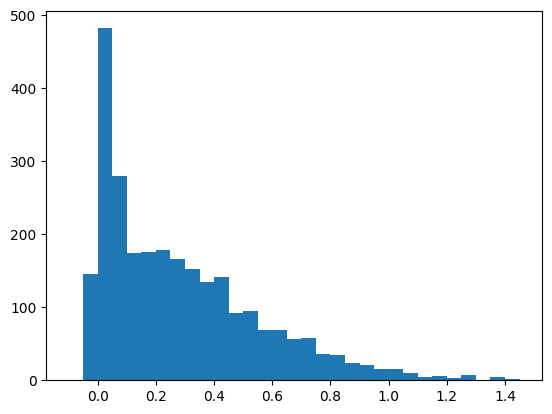

In [15]:
plt.hist(SNR, bins=np.arange(-0.1,1.5,0.05))
plt.show()

In [16]:
# plt.scatter(SNR, df['Single Trial Correlation'], alpha=0.5, s=3)
# plt.xlabel('SNR')
# plt.ylabel('Single Trial Correlation')
# plt.title('SNR vs Single Trial Correlation')
# plt.show()

In [17]:
# # Do pearson correlation
# from scipy.stats import pearsonr

# pearsonr(SNR, df['Single Trial Correlation'])

In [18]:
# # Do spearman correlation
# from scipy.stats import spearmanr

# spearmanr(SNR, df['Single Trial Correlation'])

In [19]:
%matplotlib inline

In [20]:
for i, dataset_name in enumerate(df['dataset'].drop_duplicates().values):
    df.loc[df['dataset'] == dataset_name, 'dataset'] = f'Dataset {i+1:02}'

In [21]:
plt.rcParams.update({'font.size': 32})
sns.set_theme(font_scale=3.5)

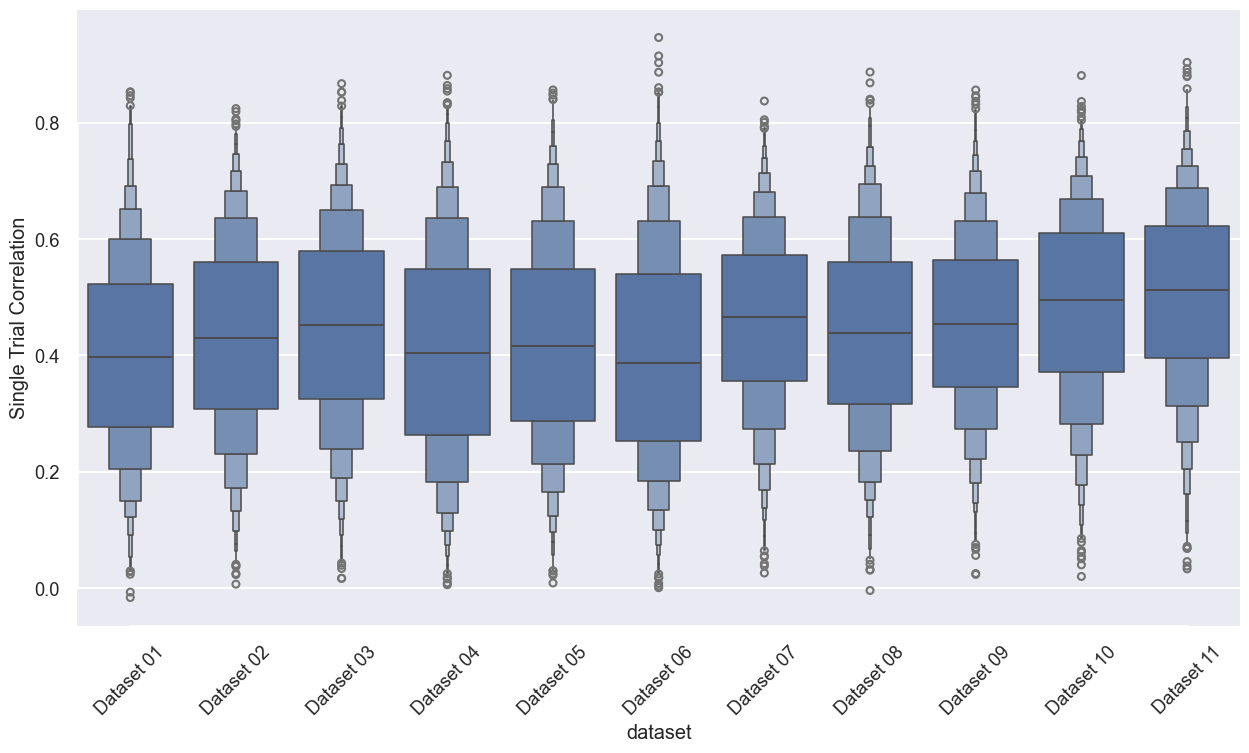

In [22]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15, 8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df)
plt.xticks(rotation=45)
sns.despine(trim=True)

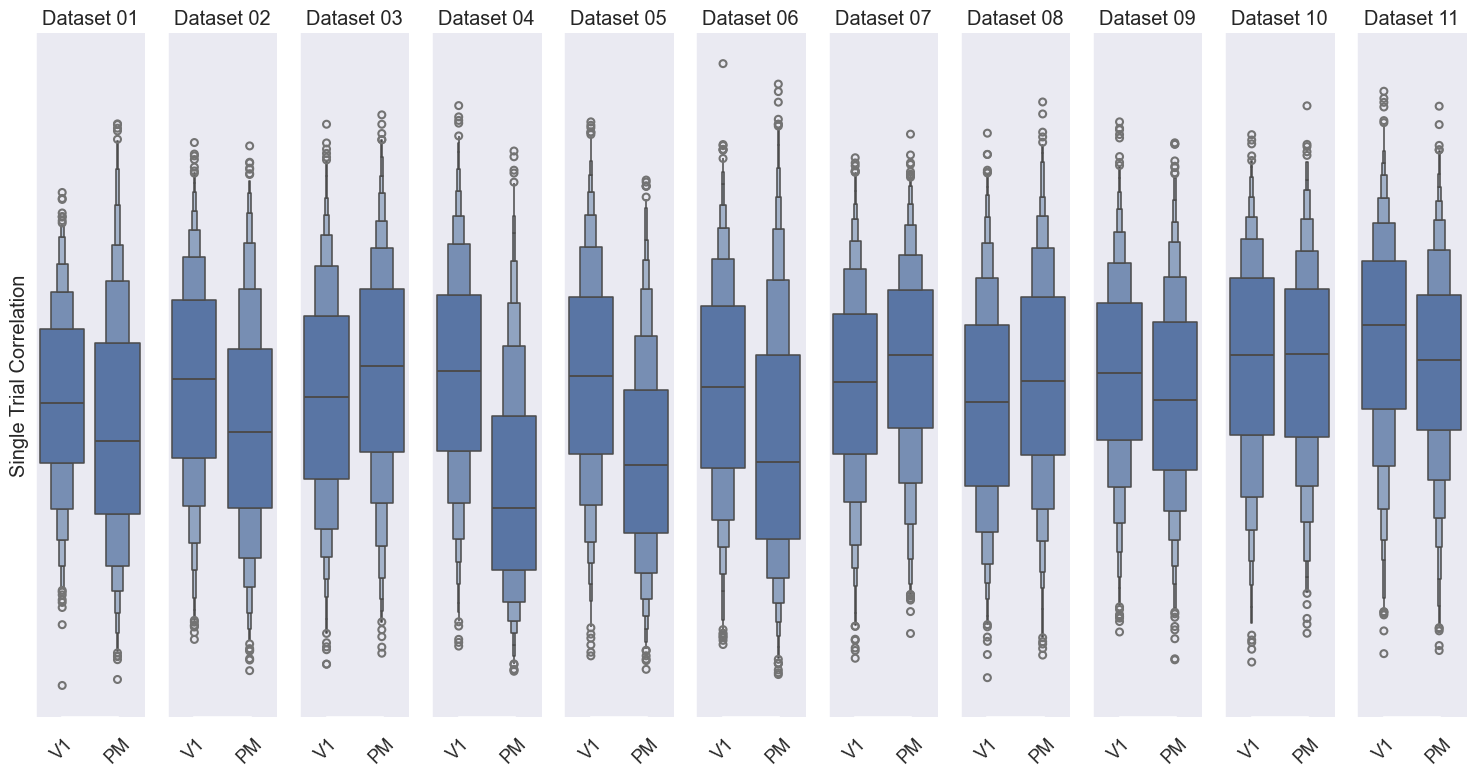

In [23]:
sns.set_context("talk", font_scale=.8)
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for idx, (ax, (i, g)) in enumerate(zip(np.array(axes).reshape(-1), df.sort_values('area', ascending = False).groupby('dataset'))):
    sns.boxenplot(x="area", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

    if idx > 0:
        # remove y axis line
        ax.spines['left'].set_visible(False)
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.get_yaxis().set_visible(False)

        for spine in ax.spines.values():
            spine.set_visible(False)            

sns.despine(trim=True)
plt.tight_layout()
plt.show()

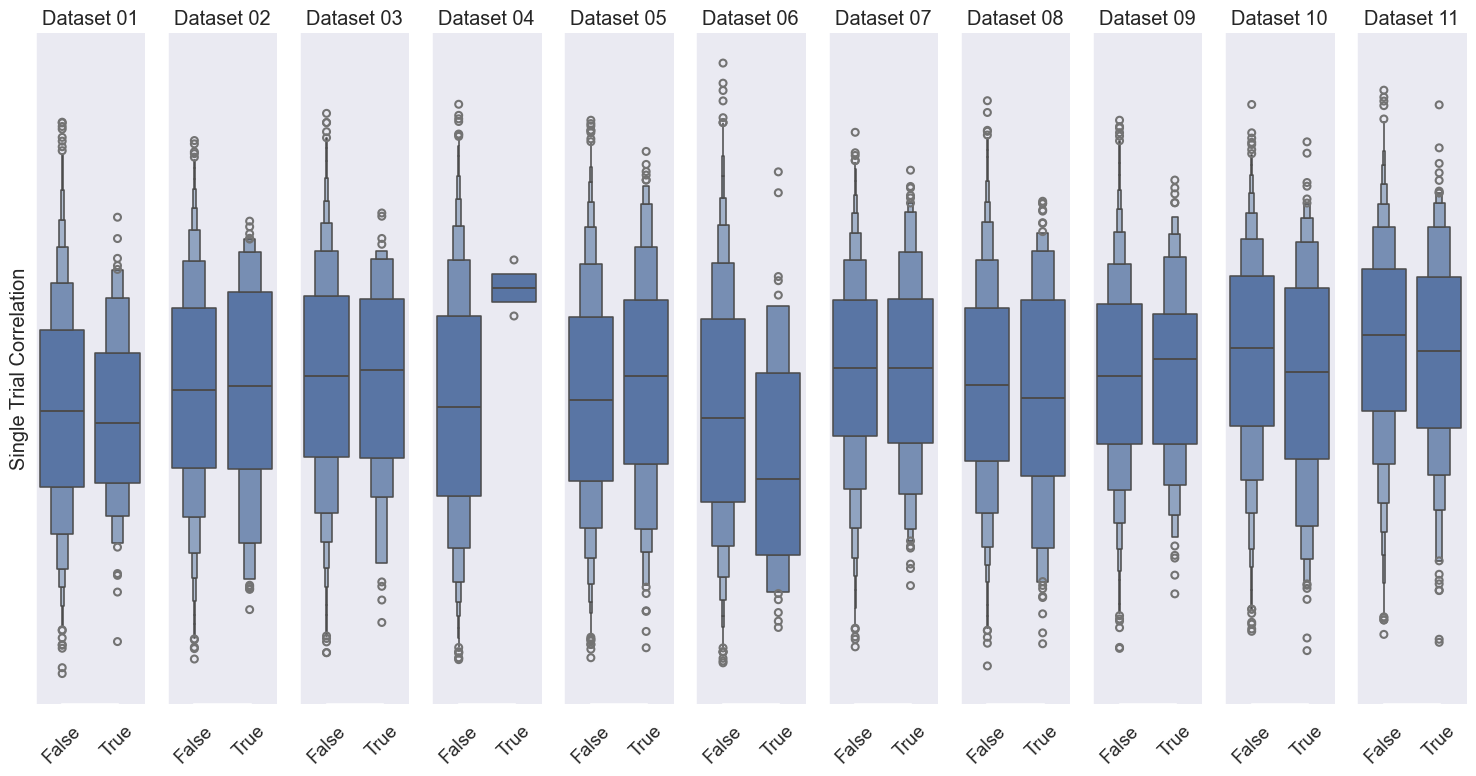

In [24]:
sns.set_context("talk", font_scale=.8)
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for idx, (ax, (i, g)) in enumerate(zip(np.array(axes).reshape(-1), df.sort_values('labeled', ascending = False).groupby('dataset'))):
    sns.boxenplot(x="labeled", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

    if idx > 0:
        # remove y axis line
        ax.spines['left'].set_visible(False)
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.get_yaxis().set_visible(False)

        for spine in ax.spines.values():
            spine.set_visible(False)            

sns.despine(trim=True)
plt.tight_layout()
plt.show()

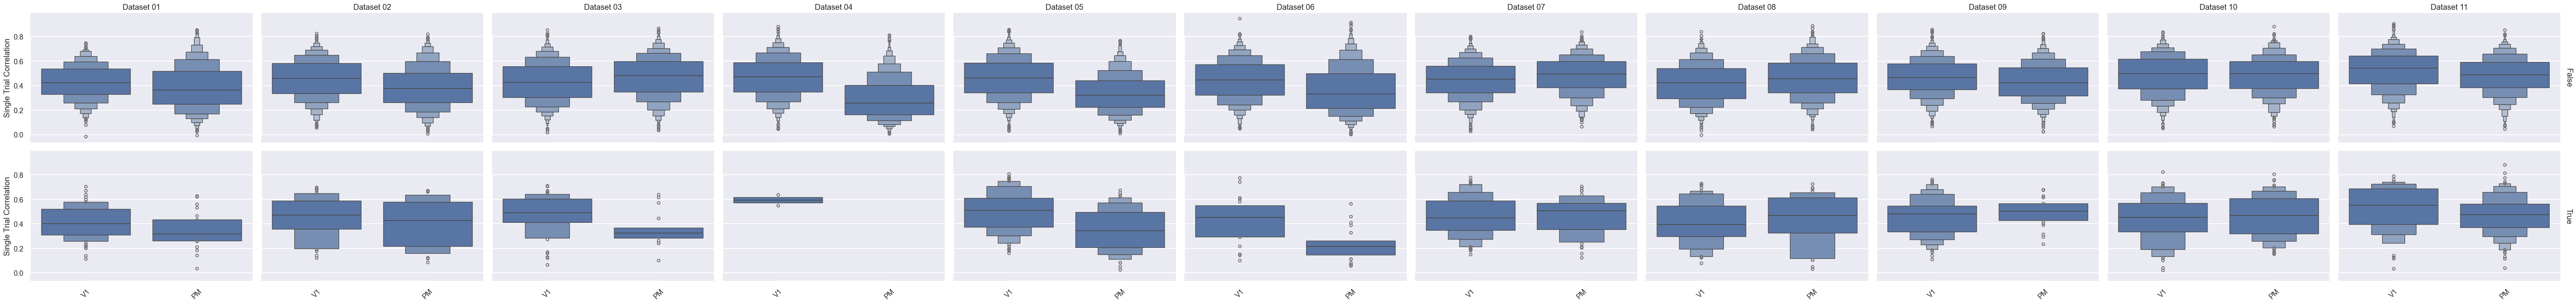

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk", font_scale=.8)

# Create a FacetGrid to split the data by 'dataset' and 'labeled'
g = sns.FacetGrid(df, col="dataset", row="labeled", margin_titles=True, height=4, aspect=1.5, sharey=True)

# Use boxenplot in each facet
g.map(sns.boxenplot, "area", "Single Trial Correlation")

# Adjust labels and titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels("", "Single Trial Correlation")

# Rotate x-tick labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Adjust layout and remove extra spines
sns.despine(trim=True)
plt.tight_layout()
plt.show()


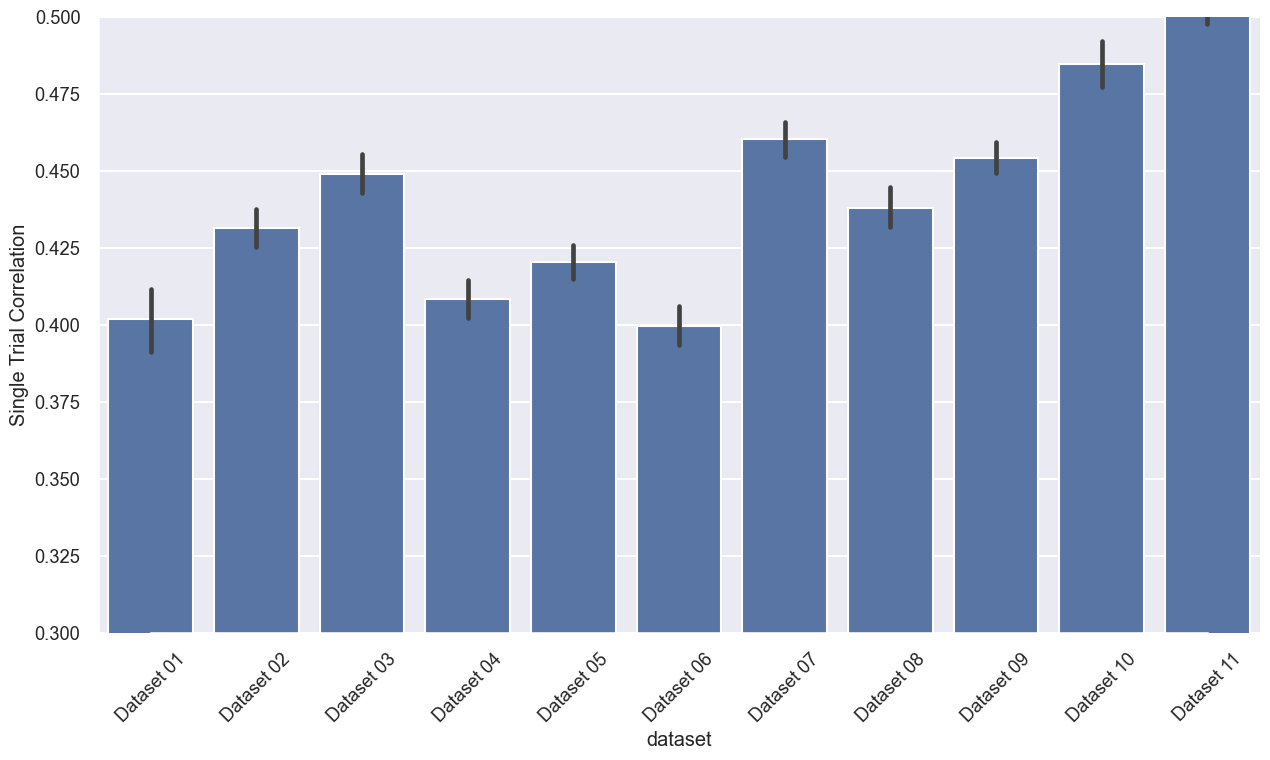

In [26]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15, 8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation=45)
plt.ylim(0.3, 0.5)
sns.despine(trim=True)

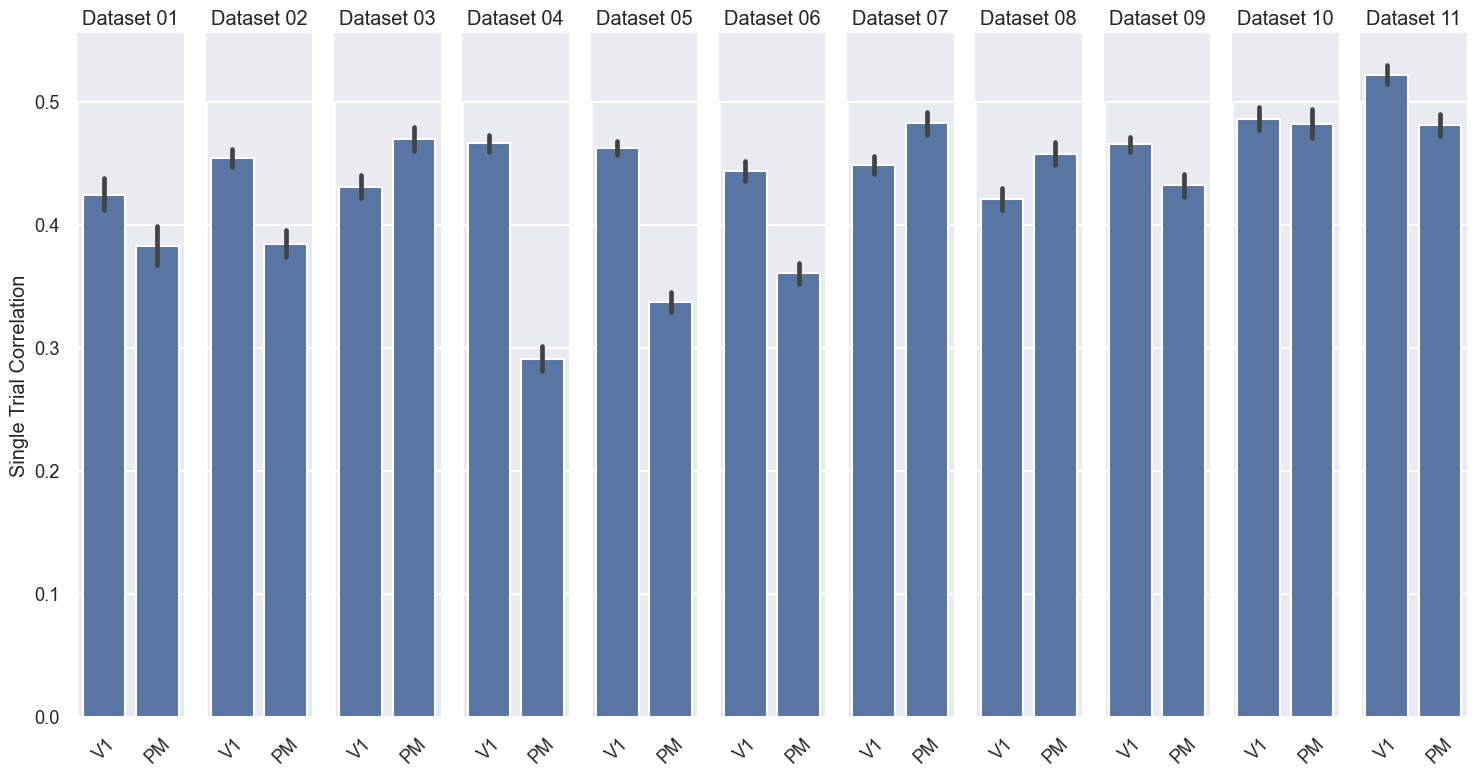

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for ax, (i, g) in zip(np.array(axes).reshape(-1), df.sort_values("area", ascending=False).groupby('dataset')):
    sns.barplot(x="area", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

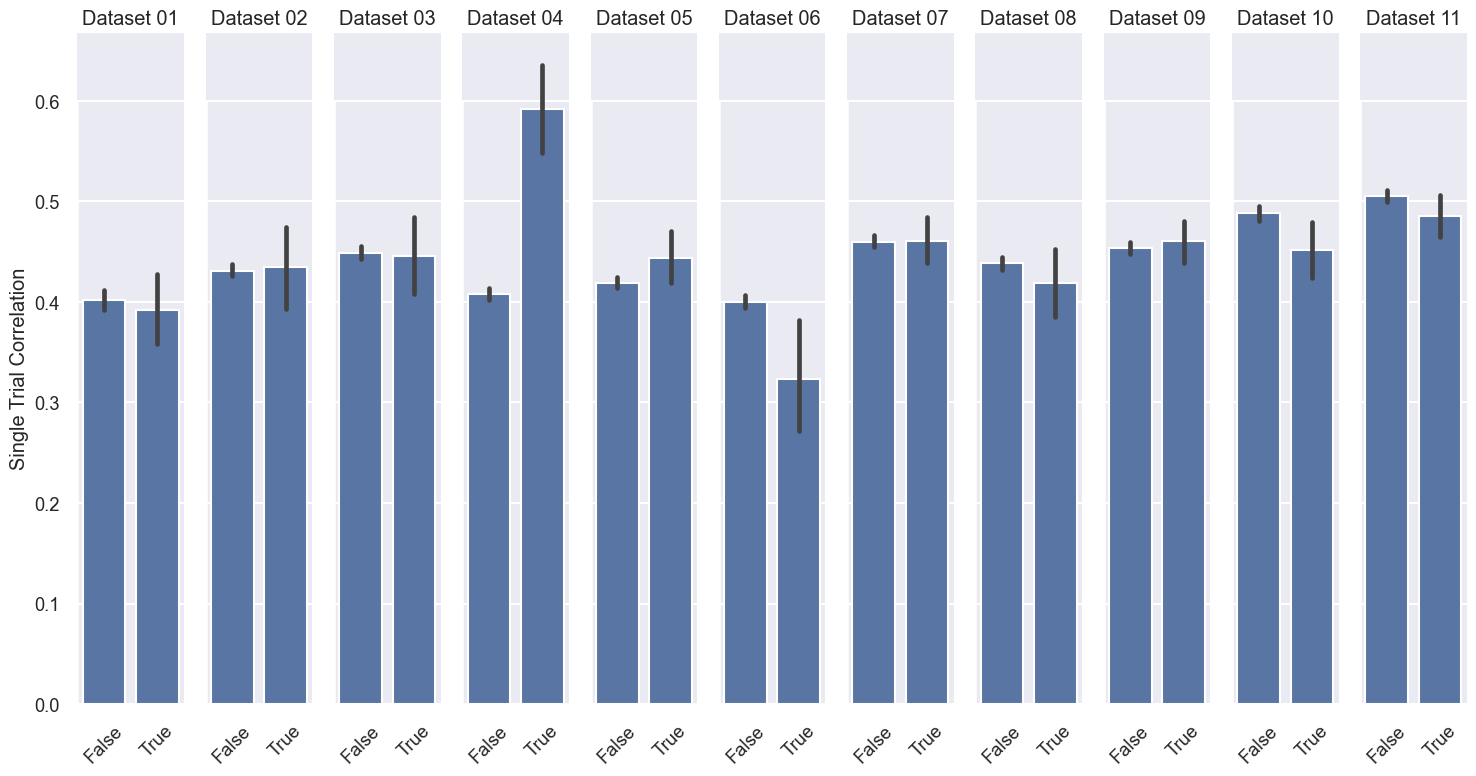

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for ax, (i, g) in zip(np.array(axes).reshape(-1), df.sort_values("labeled", ascending=False).groupby('dataset')):
    sns.barplot(x="labeled", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

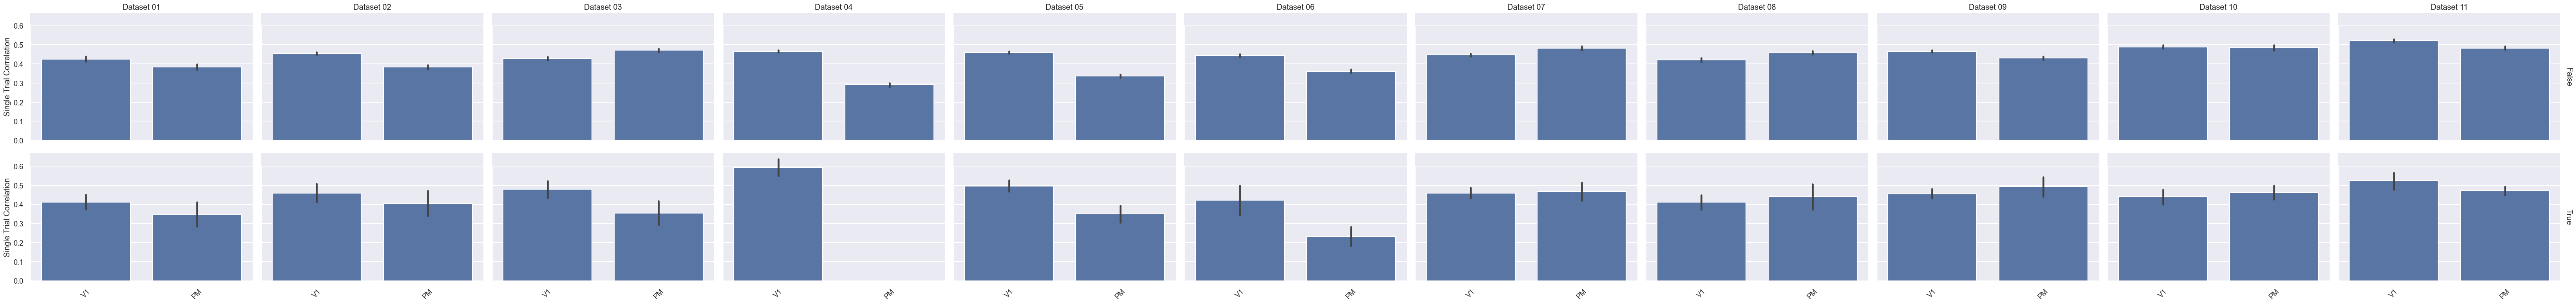

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk", font_scale=.8)

# Create a FacetGrid to split the data by 'dataset' and 'labeled'
g = sns.FacetGrid(df, col="dataset", row="labeled", margin_titles=True, height=4, aspect=1.5, sharey=True)

# Use boxenplot in each facet
g.map(sns.barplot, "area", "Single Trial Correlation")

# Adjust labels and titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels("", "Single Trial Correlation")

# Rotate x-tick labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Adjust layout and remove extra spines
sns.despine(trim=True)
plt.tight_layout()
plt.show()


In [30]:
df_desc = df.groupby('dataset').describe()
df_desc.loc[("All datasets", )] = df_desc.mean()
# I'm so sorry about this horrible one liner
df_desc.loc[("All datasets, weighted"), ] = df_desc['Single Trial Correlation'].mul((df_desc['Single Trial Correlation']['count'].values.reshape(-1, 1)) / np.sum(df_desc['Single Trial Correlation']['count'].values)).sum().values
df_desc.to_csv('notebooks/submission_m4/results/validation_pred_description.csv', index = False)
df_desc

Single Trial Correlation                                \
                                          count      mean       std       min   
dataset                                                                         
Dataset 01                          1041.000000  0.401656  0.164408 -0.016194   
Dataset 02                          2599.000000  0.431335  0.165339  0.006736   
Dataset 03                          2470.000000  0.448954  0.165969  0.016740   
Dataset 04                          3246.000000  0.408434  0.182622  0.005786   
Dataset 05                          4169.000000  0.420232  0.169862  0.008792   
Dataset 06                          3273.000000  0.399458  0.182589  0.000720   
Dataset 07                          2585.000000  0.460092  0.149891  0.025955   
Dataset 08                          2432.000000  0.437859  0.163688 -0.004140   
Dataset 09                          2974.000000  0.454065  0.148646  0.023540   
Dataset 10                          1798.000000  0.484621  0.159039  0.019994   
Dataset 11                          2663.000000  0.503293  0.155183  0.033077   
All datasets                        2659.090909  0.440909  0.164294  0.011001   
All datasets, weighted              2864.564544  0.439432  0.165253  0.011912   

                                                                
                             25%       50%       75%       max  
dataset                                                         
Dataset 01              0.277822  0.397077  0.523085  0.853411  
Dataset 02              0.307357  0.430616  0.561024  0.824493  
Dataset 03              0.325688  0.453120  0.579283  0.867381  
Dataset 04              0.263950  0.404484  0.547900  0.881699  
Dataset 05              0.287944  0.416921  0.548039  0.856519  
Dataset 06              0.252793  0.386427  0.540673  0.946700  
Dataset 07              0.356845  0.466178  0.572582  0.837508  
Dataset 08              0.317179  0.438369  0.560222  0.887316  
Dataset 09              0.345881  0.454853  0.564402  0.856534  
Dataset 10              0.370918  0.496158  0.610495  0.881360  
Dataset 11              0.394902  0.512748  0.621841  0.903915  
All datasets            0.318298  0.441541  0.566323  0.872439  
All datasets, weighted  0.315411  0.439472  0.565576  0.873952

In [31]:
num_neurons = df_desc['Single Trial Correlation']['count'].iloc[0].astype(int)

In [32]:
mus = np.zeros((5, num_neurons, 2))
sigmas = np.zeros((5, num_neurons, 2, 2))

In [33]:
model.readout._modules

OrderedDict([('LPE09665-LPE09665_2023_03_20-0',
              full FullGaussian2d (64 x 12 x 29 -> 1041) with bias, with predicted grid  -> Sequential(
                (0): Linear(in_features=2, out_features=20, bias=True)
                (1): ReLU()
                (2): Linear(in_features=20, out_features=20, bias=True)
                (3): ReLU()
                (4): Linear(in_features=20, out_features=20, bias=True)
                (5): ReLU()
                (6): Linear(in_features=20, out_features=20, bias=True)
                (7): ReLU()
                (8): Linear(in_features=20, out_features=2, bias=True)
                (9): Tanh()
              )),
             ('LPE10883-LPE10883_2023_10_23-0',
              full FullGaussian2d (64 x 12 x 29 -> 2599) with bias, with predicted grid  -> Sequential(
                (0): Linear(in_features=2, out_features=20, bias=True)
                (1): ReLU()
                (2): Linear(in_features=20, out_features=20, bias=True)
         

In [34]:
for i, model in enumerate(model_list):
    mus[i] = model.readout._modules['LPE10885-LPE10885_2023_10_20-0'].mu.detach().cpu().numpy().reshape(-1, 2)
    sigmas[i] = model.readout._modules['LPE10885-LPE10885_2023_10_20-0'].sigma.detach().cpu().numpy().reshape(-1, 2, 2)

ValueError: could not broadcast input array from shape (4169,2) into shape (1041,2)

In [33]:
raise NotImplementedError("Save as np arrays instead of CSV")

NotImplementedError: Save as np arrays instead of CSV

In [34]:
df_neuron_stats = pd.DataFrame(columns=['dataset', 'neuron', 'mean', 'cov', 'mean_std', 'cov_std'] + [f'mean_{i}' for i in range(5)] + [f'cov_{i}' for i in range(5)])

df_neuron_stats['dataset'] = df['dataset']
df_neuron_stats['neuron'] = np.repeat(np.arange(num_neurons), len(df['dataset'].unique()))
for i in range(5):
    df_neuron_stats[f'mean_{i}'] = list(mus[i].round(2))
    df_neuron_stats[f'cov_{i}'] = list(sigmas[i].round(2))

df_neuron_stats['mean'] = list(mus.mean(axis=0).round(2))
df_neuron_stats['cov'] = list(sigmas.mean(axis=0).round(2))

df_neuron_stats['mean_std'] = list(mus.std(axis=0).round(2))
df_neuron_stats['cov_std'] = list(sigmas.std(axis=0).round(2))

In [35]:
df_neuron_stats['single_trial_correlation'] = df['Single Trial Correlation']
df_neuron_stats['cell_id'] = df['cell_id']

In [36]:
df_neuron_stats.to_csv('notebooks/submission_m4/results/neuron_stats.csv', index = False)

In [37]:
df_neuron_stats

,dataset,neuron,mean,cov,mean_std,cov_std,mean_0,mean_1,mean_2,mean_3,mean_4,cov_0,cov_1,cov_2,cov_3,cov_4,single_trial_correlation,cell_id
0,LPE10885-LPE10885_2023_10_20-0,0,"[0.1, 0.14]","[[-0.0, -0.0], [-0.0, -0.0]]","[0.38, 0.1]","[[0.01, 0.01], [0.0, 0.01]]","[-0.08, 0.01]","[-0.13, 0.08]","[0.03, 0.27]","[0.85, 0.08]","[-0.16, 0.26]","[[0.01, -0.01], [0.0, 0.0]]","[[-0.0, 0.01], [-0.0, 0.0]]","[[-0.01, -0.0], [-0.0, -0.01]]","[[0.0, -0.01], [-0.0, -0.01]]","[[-0.01, 0.01], [0.01, -0.0]]",0.838086,LPE10885_2023_10_20_0_0000
1,LPE10885-LPE10885_2023_10_20-0,1,"[-0.03, 0.14]","[[0.0, 0.0], [0.01, -0.0]]","[0.41, 0.1]","[[0.02, 0.02], [0.01, 0.02]]","[-0.38, 0.04]","[-0.22, 0.07]","[-0.05, 0.28]","[0.77, 0.07]","[-0.25, 0.26]","[[-0.02, -0.0], [0.0, -0.01]]","[[-0.0, 0.01], [0.01, 0.02]]","[[0.01, 0.01], [0.0, 0.03]]","[[0.02, -0.04], [-0.0, -0.03]]","[[0.02, 0.03], [0.01, -0.02]]",0.169588,LPE10885_2023_10_20_0_0001
2,LPE10885-LPE10885_2023_10_20-0,2,"[-0.04, 0.15]","[[0.0, -0.0], [0.0, -0.0]]","[0.42, 0.1]","[[0.01, 0.01], [0.0, 0.01]]","[-0.41, 0.05]","[-0.23, 0.07]","[-0.06, 0.28]","[0.77, 0.07]","[-0.26, 0.26]","[[-0.01, 0.01], [0.0, -0.01]]","[[-0.01, -0.01], [-0.0, 0.01]]","[[0.01, -0.01], [0.01, -0.01]]","[[0.01, 0.0], [0.0, -0.0]]","[[0.01, 0.0], [0.01, 0.0]]",0.782436,LPE10885_2023_10_20_0_0002
3,LPE10885-LPE10885_2023_10_20-0,3,"[0.01, 0.14]","[[-0.0, 0.0], [0.0, 0.0]]","[0.4, 0.1]","[[0.01, 0.01], [0.01, 0.02]]","[-0.28, 0.02]","[-0.2, 0.07]","[-0.03, 0.27]","[0.78, 0.07]","[-0.22, 0.26]","[[-0.01, 0.0], [-0.0, -0.03]]","[[0.01, 0.02], [-0.0, 0.03]]","[[-0.02, -0.0], [-0.02, 0.0]]","[[0.0, 0.0], [0.01, 0.01]]","[[-0.01, -0.01], [0.02, 0.01]]",0.572170,LPE10885_2023_10_20_0_0003
4,LPE10885-LPE10885_2023_10_20-0,4,"[0.1, 0.14]","[[-0.01, -0.0], [-0.02, -0.0]]","[0.38, 0.1]","[[0.01, 0.01], [0.02, 0.01]]","[-0.09, 0.01]","[-0.13, 0.08]","[0.03, 0.27]","[0.85, 0.08]","[-0.16, 0.26]","[[-0.01, 0.01], [-0.03, -0.01]]","[[-0.01, -0.01], [-0.0, 0.01]]","[[-0.0, -0.01], [-0.01, -0.02]]","[[0.01, -0.01], [0.01, -0.0]]","[[-0.03, 0.01], [-0.05, -0.01]]",0.450413,LPE10885_2023_10_20_0_0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,LPE10885-LPE10885_2023_10_20-0,1395,"[0.1, 0.14]","[[-0.0, -0.01], [0.02, 0.0]]","[0.37, 0.1]","[[0.01, 0.01], [0.01, 0.04]]","[-0.07, 0.01]","[-0.12, 0.09]","[0.01, 0.26]","[0.84, 0.08]","[-0.16, 0.26]","[[0.01, -0.01], [0.02, 0.0]]","[[-0.0, -0.01], [0.03, -0.03]]","[[-0.02, 0.01], [0.03, -0.02]]","[[0.02, -0.0], [0.01, -0.01]]","[[-0.01, -0.01], [-0.01, 0.07]]",0.208128,LPE10885_2023_10_20_3_0343
1396,LPE10885-LPE10885_2023_10_20-0,1396,"[0.12, 0.14]","[[0.0, -0.01], [-0.01, -0.0]]","[0.37, 0.1]","[[0.01, 0.01], [0.02, 0.01]]","[-0.04, 0.01]","[-0.11, 0.1]","[0.03, 0.27]","[0.85, 0.08]","[-0.15, 0.26]","[[0.0, -0.01], [0.03, 0.0]]","[[-0.01, -0.0], [0.01, -0.0]]","[[-0.01, 0.0], [-0.03, -0.03]]","[[0.0, -0.0], [-0.01, -0.0]]","[[0.02, -0.01], [-0.02, 0.0]]",0.217244,LPE10885_2023_10_20_3_0344
1397,LPE10885-LPE10885_2023_10_20-0,1397,"[0.1, 0.14]","[[-0.01, -0.01], [0.01, 0.01]]","[0.38, 0.1]","[[0.01, 0.01], [0.01, 0.01]]","[-0.07, 0.01]","[-0.13, 0.08]","[0.01, 0.26]","[0.84, 0.08]","[-0.17, 0.26]","[[-0.01, 0.0], [0.02, 0.01]]","[[-0.01, -0.0], [0.01, 0.01]]","[[-0.02, -0.03], [-0.0, 0.01]]","[[-0.01, 0.01], [-0.01, -0.02]]","[[0.01, -0.01], [0.02, 0.02]]",0.171497,LPE10885_2023_10_20_3_0346
1398,LPE10885-LPE10885_2023_10_20-0,1398,"[-0.05, 0.15]","[[-0.01, -0.01], [-0.01, -0.01]]","[0.42, 0.1]","[[0.01, 0.01], [0.03, 0.04]]","[-0.43, 0.05]","[-0.24, 0.07]","[-0.06, 0.29]","[0.77, 0.07]","[-0.27, 0.26]","[[-0.0, -0.0], [0.03, -0.01]]","[[-0.01, -0.02], [-0.05, -0.08]]","[[-0.02, -0.0], [-0.01, -0.01]]","[[0.01, 0.0], [0.0, 0.01]]","[[-0.0, -0.01], [-0.01, 0.06]]",0.248505,LPE10885_2023_10_20_3_0350


In [34]:
df

,dataset,Single Trial Correlation,area,labeled,cell_id
0,LPE10885-LPE10885_2023_10_20-0,0.746902,PM,False,LPE10885_2023_10_20_0_0000
1,LPE10885-LPE10885_2023_10_20-0,0.291432,PM,False,LPE10885_2023_10_20_0_0001
2,LPE10885-LPE10885_2023_10_20-0,0.598873,PM,False,LPE10885_2023_10_20_0_0002
3,LPE10885-LPE10885_2023_10_20-0,0.522241,PM,False,LPE10885_2023_10_20_0_0003
4,LPE10885-LPE10885_2023_10_20-0,0.641643,PM,False,LPE10885_2023_10_20_0_0004
...,...,...,...,...,...
1395,LPE10885-LPE10885_2023_10_20-0,0.092515,PM,False,LPE10885_2023_10_20_3_0343
1396,LPE10885-LPE10885_2023_10_20-0,0.369304,PM,False,LPE10885_2023_10_20_3_0344
1397,LPE10885-LPE10885_2023_10_20-0,0.201283,PM,False,LPE10885_2023_10_20_3_0346
1398,LPE10885-LPE10885_2023_10_20-0,0.098284,PM,False,LPE10885_2023_10_20_3_0350


In [39]:
# Get fit parameters from the readout, ie x and y coordinates of spatial mask